In [1]:
import os
import sys

sys.path.append('..')

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import itertools
import pickle
import time
import numpy as np

In [2]:
# Get the project root directory
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Append the src directory to the Python path
sys.path.append(os.path.join(ROOT_DIR, 'src'))

from preprocessing import preprocess_text, extract_features, preprocess_data


# Preprocess the data
data_path = os.path.join(ROOT_DIR, 'raw_data')

train_data, test_data = preprocess_data(data_path)


# Create the data directory if it doesn't exist
data_dir = os.path.join(ROOT_DIR, 'data')
os.makedirs(data_dir, exist_ok=True)

# Save train and test data as CSV files
train_data.to_csv(os.path.join(data_dir, 'train.csv'), index=False)
test_data.to_csv(os.path.join(data_dir, 'test.csv'), index=False)
    
# print(train_data)
# print(test_data)

[nltk_data] Downloading package punkt to /home/u1027874/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u1027874/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u1027874/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Split data into features and target
X_train = train_data.drop('acuity', axis=1)
y_train = train_data['acuity']
X_test = test_data.drop('acuity', axis=1)
y_test = test_data['acuity']

In [4]:
def PlotROCCurve(y_probs, y_true, ci=None, random_seed=None, curve_color='green'):
    """
    Plots the ROC curve for a multi-class classification problem using one-vs-rest strategy
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Binarize the labels
    y_true = label_binarize(y_true, classes=np.unique(y_true))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], color="purple", lw=2, label=f'ROC curve (AUC = {roc_auc["micro"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    if ci is not None:
        tprs_upper = []
        tprs_lower = []
        for fpr_val in np.linspace(0, 1, 100):
            tprs_upper.append(np.interp(fpr_val, fpr["micro"], tpr["micro"] + ci / 2))
            tprs_lower.append(np.interp(fpr_val, fpr["micro"], tpr["micro"] - ci / 2))
        plt.fill_between(np.linspace(0, 1, 100), tprs_lower, tprs_upper, color='grey', alpha=0.2)

    plt.show()

In [5]:
def train_model(train_data, test_data, model_path, confidence_interval, random_seed):
    # Define the MLPClassifier model
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, early_stopping=True)

    # Train the model
    start = time.time()
    mlp.fit(X_train, y_train)
    runtime = time.time() - start
    print('Training time:', runtime, 'seconds')

    # Save the trained model
    with open(f'{model_path}/model.pkl', 'wb') as f:
        pickle.dump(mlp, f)
        
    return mlp


In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

classes = np.unique(y_test)  # Get the list of unique class labels

In [7]:
def evaluate_model(mlp, X_test, y_test, confidence_interval, random_seed, model_path, classes):
    """
    Evaluates the performance of a multi-class classification model and saves the trained model
    """
    # Get predicted probabilities
    probs = mlp.predict_proba(X_test)

    # Plot ROC curve
    PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed, curve_color='red')

    # Get predicted labels
    y_pred = mlp.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate the true positives, true negatives, false positives, and false negatives
    tn = np.sum(cm, axis=1) - np.diag(cm)
    tn = np.sum(tn)
    tp = np.diag(cm)
    tp = np.sum(tp)
    fn = np.sum(cm, axis=0) - np.diag(cm)
    fp = np.sum(cm) - tp - tn - fn

    # Print the values
    print(f'True Positives: {tp}')
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')

    # Compute ROC AUC using the one-vs-rest strategy
    auc_ovr = roc_auc_score(y_test, probs, multi_class='ovr')
    print(f'AUC (one-vs-rest): {auc_ovr}')

    # Compute ROC AUC using the one-vs-one strategy
    auc_ovo = roc_auc_score(y_test, probs, multi_class='ovo')
    print(f'AUC (one-vs-one): {auc_ovo}')

    # Reshape the predicted probabilities into a 2D array
    probs_2d = probs[:, 1].reshape(-1, 1)

    # Calculate AUPRC
    auprc = average_precision_score(y_test, probs_2d)
    print(f'AUPRC: {auprc}')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes, normalize=True, title='Normalized Confusion Matrix')

Training time: 2.304227352142334 seconds
Training time: 2.9919891357421875 seconds


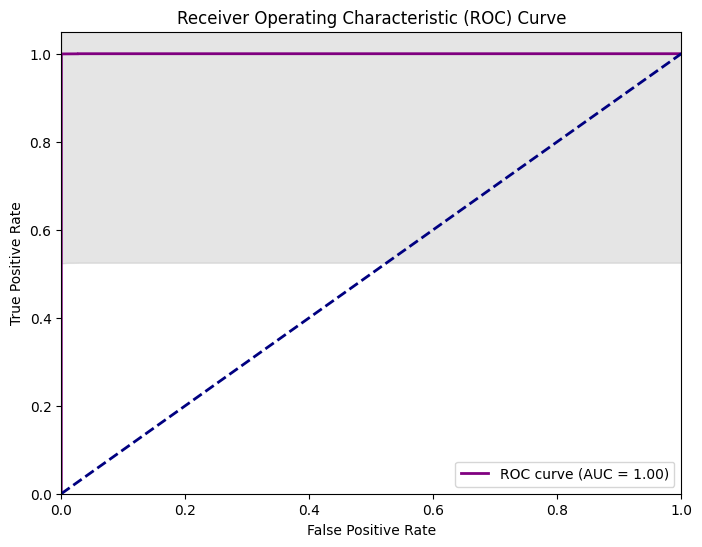

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       132
           2       1.00      1.00      1.00      2143
           3       1.00      1.00      1.00      2010
           4       1.00      1.00      1.00        52

    accuracy                           1.00      4337
   macro avg       1.00      1.00      1.00      4337
weighted avg       1.00      1.00      1.00      4337

True Positives: 4335
True Negatives: 2
False Positives: [ 0  0 -2  0]
False Negatives: [0 0 2 0]
AUC (one-vs-rest): 0.9999783807155983
AUC (one-vs-one): 0.9999857425706772
AUPRC: 0.01942940415384553
Accuracy: 0.9995388517408347


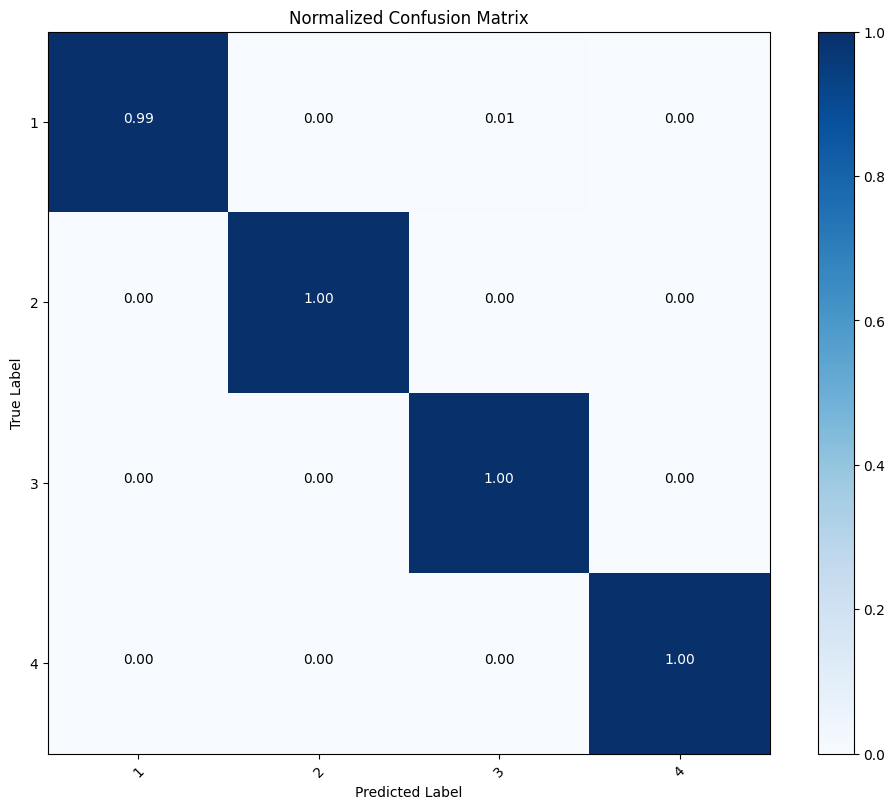

In [8]:
# Create the models directory if it doesn't exist
models_dir = os.path.join(ROOT_DIR, 'models')
os.makedirs(models_dir, exist_ok=True)

model_path = models_dir

confidence_interval = 0.95
random_seed = 42  

train_model(train_data, test_data, model_path, confidence_interval, random_seed)

# Call the train_model function and store the returned value for use in evaluate_model
trained_model = train_model(train_data, test_data, model_path, confidence_interval, random_seed)

# Get the list of unique class labels
classes = np.unique(y_test)

# Evaluate the model
# evaluate_model(mlp, X_test, y_test, confidence_interval, random_seed, model_path, classes)

# Call the evaluate_model function and pass the trained_model
evaluate_model(trained_model, X_test, y_test, confidence_interval, random_seed, model_path, classes)